In [44]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [45]:
from torchvision import transforms, datasets
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
asl_train_dataset = datasets.ImageFolder(root='./asl_alphabet_train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(asl_train_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

/home/gandhar/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:935: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [46]:
print(asl_train_dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [47]:
random_seed = 42
torch.manual_seed(random_seed);
print(len(asl_train_dataset))

87000


In [48]:
val_size = 7000
test_size = 14000
train_size = len(asl_train_dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(asl_train_dataset, [train_size, val_size, test_size])

print(len(train_ds), len(val_ds), len(test_ds))

66000 7000 14000


In [49]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [51]:
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [54]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
model.to(device)

Using cache found in /home/gandhar/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
import datetime  # <1>

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
    
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    correctt=0
    totalt=0
   
    at = 0 
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            imgs=imgs.to(device)
            labels=labels.to(device)
            
            outputs = model(imgs)#  <2>  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>
            at = loss_train / len(train_loader)
            train_losses.append(at)

        if epoch == 1 or epoch % 5 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>
       
        with torch.no_grad():
            for imgs, labels in train_loader:
                imgs=imgs.to(device)
                labels=labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
            totalt += labels.shape[0]
            correctt += int((predicted == labels).sum())
            acctt = float(correctt/totalt)
            train_accuracy.append(acctt)
    print("Accuracy in Training: ",acctt)   

In [56]:
train_loader = torch.utils.data.DataLoader(train_dl, batch_size=64,
                                           shuffle=True)  # <1>

val_loader = torch.utils.data.DataLoader(val_dl, batch_size=64,
                                         shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=3e-3)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_dl,
)
# Training time: 2 hrs 37 min

2022-05-10 11:15:14.177054 Epoch 1, Training loss 3.460472155680028
2022-05-10 11:28:03.339850 Epoch 5, Training loss 2.10792328290237
2022-05-10 11:44:10.425155 Epoch 10, Training loss 1.3125503379707189
2022-05-10 12:00:16.850485 Epoch 15, Training loss 0.9429386276029801
2022-05-10 12:16:27.800314 Epoch 20, Training loss 0.7478799996680991
2022-05-10 12:32:31.212393 Epoch 25, Training loss 0.631186280543952
2022-05-10 12:48:30.781028 Epoch 30, Training loss 0.542376376760676
2022-05-10 13:04:26.463705 Epoch 35, Training loss 0.4828043914320626
2022-05-10 13:20:24.561834 Epoch 40, Training loss 0.43359821662306786
2022-05-10 13:36:25.651636 Epoch 45, Training loss 0.3956758601071183
2022-05-10 13:52:30.762074 Epoch 50, Training loss 0.3691334267139666
Accuracy in Training:  0.59375


In [57]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_dl), ("val", val_dl)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)  # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name, correct / total))
        acc = correct / total
    return acc

accuracy_val = validate(model, train_loader, val_loader)

Accuracy train: 0.87
Accuracy val: 0.88


In [58]:
torch.save(model.state_dict(),"ASL-Resnet-50.pt")

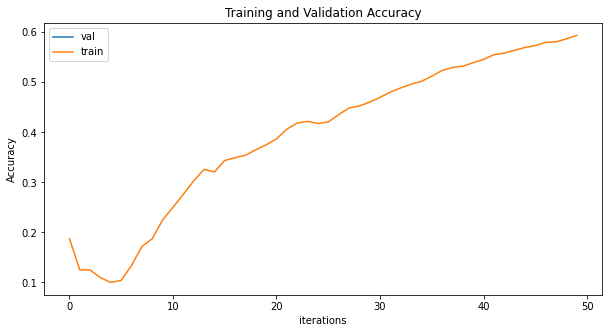

In [59]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy,label="val")
plt.plot(train_accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

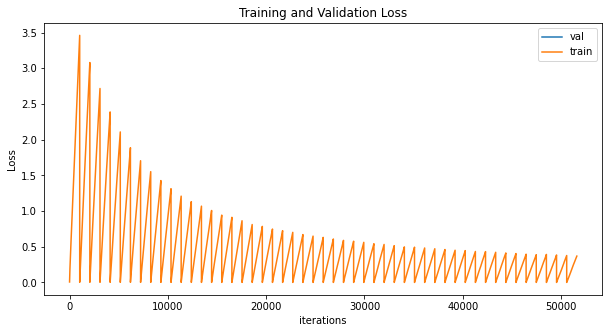

In [60]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
train_loader = torch.utils.data.DataLoader(train_dl, batch_size=64,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dl, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, test_loader):
    for name, loader in [("train", train_dl), ("test", test_dl)]:
        correct = 0
        total = 0
        a = 0 
        #val_losses = []
        #val_accuracy = []

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs=imgs.to(device)
                labels=labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
                #val_losses.append(loss)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>
                a = correct / total
                #val_accuracy.append(a)
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        print("Loss: ",loss)

validate(model, train_loader, test_loader)

Accuracy train: 0.87
Loss:  tensor(0.5725, device='cuda:0')
Accuracy test: 0.88
Loss:  tensor(0.7108, device='cuda:0')


In [62]:
import torchvision.models as models
from ptflops import get_model_complexity_info

net = model
macs, params = get_model_complexity_info(net, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  25.557 M, 100.000% Params, 0.338 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.037% Params, 0.01 GMac, 2.847% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.039% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.019% MACs, inplace=True)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.0 GMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.216 M, 0.844% Params, 0.056 GMac, 16.415% MACs, 
    (0): Bottleneck(
      0.075 M, 0.293% Params, 0.019 GMac, 5.704% MACs, 
      (conv1): Conv2d(0.004 M, 0.016% Params, 0.001 GMac, 0.310% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.010% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(0.037 M, 0.144% 

In [63]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(25557032,
 [9408,
  64,
  64,
  4096,
  64,
  64,
  36864,
  64,
  64,
  16384,
  256,
  256,
  16384,
  256,
  256,
  16384,
  64,
  64,
  36864,
  64,
  64,
  16384,
  256,
  256,
  16384,
  64,
  64,
  36864,
  64,
  64,
  16384,
  256,
  256,
  32768,
  128,
  128,
  147456,
  128,
  128,
  65536,
  512,
  512,
  131072,
  512,
  512,
  65536,
  128,
  128,
  147456,
  128,
  128,
  65536,
  512,
  512,
  65536,
  128,
  128,
  147456,
  128,
  128,
  65536,
  512,
  512,
  65536,
  128,
  128,
  147456,
  128,
  128,
  65536,
  512,
  512,
  131072,
  256,
  256,
  589824,
  256,
  256,
  262144,
  1024,
  1024,
  524288,
  1024,
  1024,
  262144,
  256,
  256,
  589824,
  256,
  256,
  262144,
  1024,
  1024,
  262144,
  256,
  256,
  589824,
  256,
  256,
  262144,
  1024,
  1024,
  262144,
  256,
  256,
  589824,
  256,
  256,
  262144,
  1024,
  1024,
  262144,
  256,
  256,
  589824,
  256,
  256,
  262144,
  1024,
  1024,
  262144,
  256,
  256,
  589824,
  256,
  256,
  26